### D-Wave Maximum Cut

https://github.com/dwave-examples/maximum-cut

In this demo, we explore the maximum cut problem. This problem has a wide variety of real-world applications.

For example, suppose that we have a set of different computers, each with different types of connections. Some computers have bluetooth, some have USB ports, HDMI ports, etc. We want to split our set of computers into two groups for two different projects, but it's very important that the two groups can connect to each other. The problem is sometimes the wires and connections don't work! How can we be sure that we have the best chance at remaining connected?

One way to solve this problem is with the maximum cut problem. If we think of our set of computers as a graph (a node/vertex for each computer), and draw an edge between computers that can connect to each other, we have a model of our network. If we look for a maximum cut in our graph, then we are looking for a way to split the nodes into two groups so that there are as many edges as possible between the groups. In our computer set, this means that we have two groups with as many connections as possible between the two groups. Now if one connection goes down, we have many more to use! This way we have created a more resilient network by providing many redundant connections between groups in case one connection fails.

Below we see a simple network of five nodes and three different ways to split the set of nodes into two groups. The dashed edges in each graph highlight the cut edges.

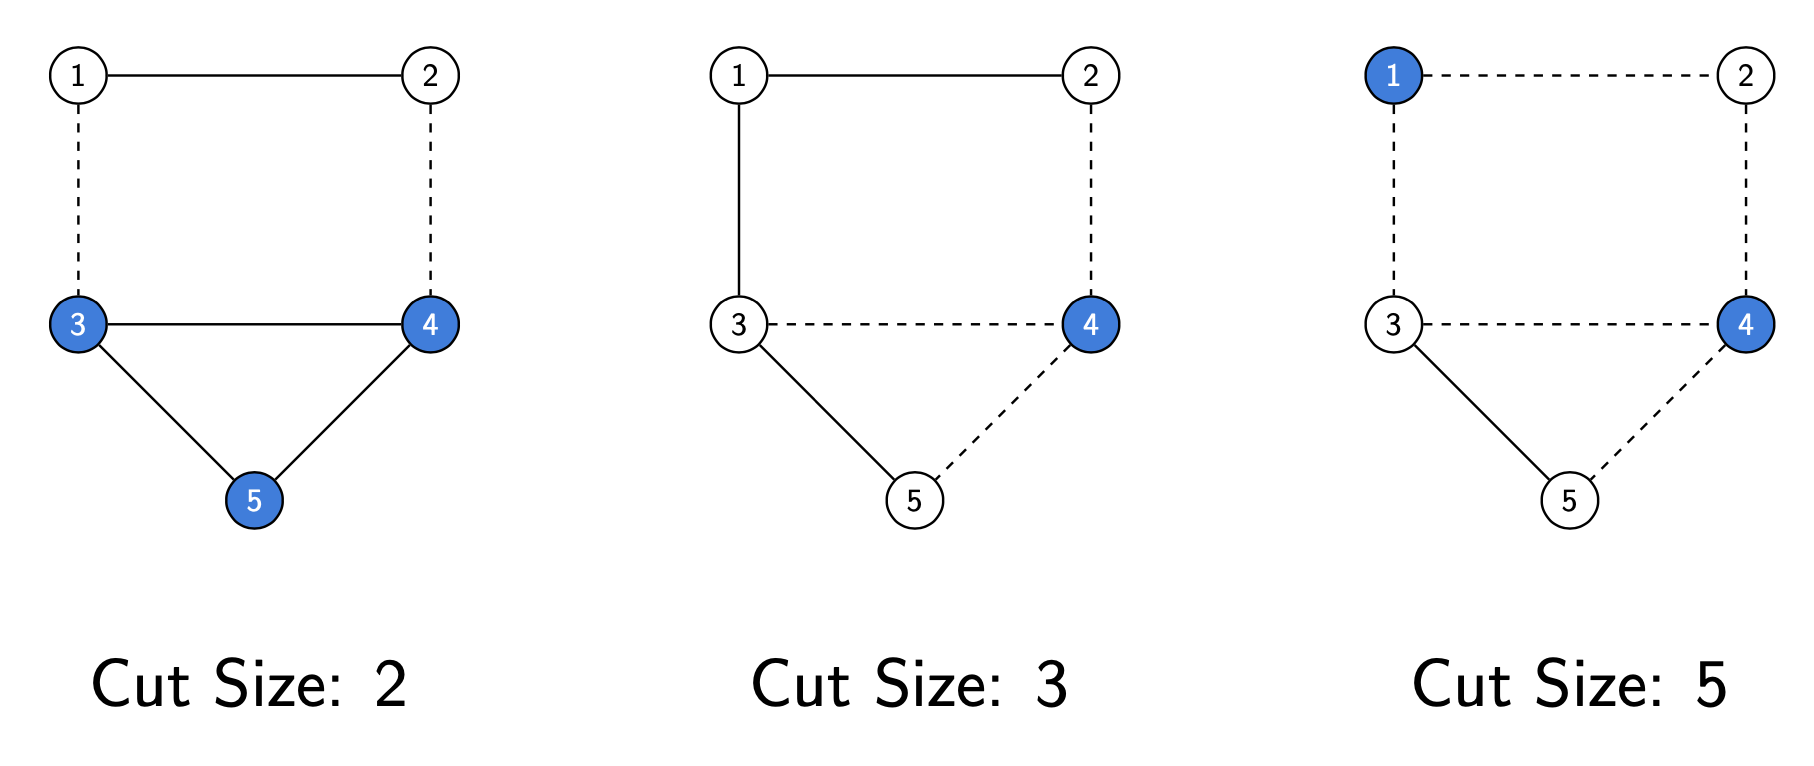

We will run the maximum cut problem on the network shown above to find the best way to split the network into two groups to maximize the number of cut edges.